<a href="https://colab.research.google.com/github/osjayaprakash/deeplearning/blob/main/CS_230_Full_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
root_dir = kagglehub.dataset_download("shahrukhkhan/im2latex100k")
# path = kagglehub.dataset_download("gregoryeritsyan/im2latex-230k")

print("Path to dataset files:", root_dir)

100%|██████████| 631M/631M [00:14<00:00, 45.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7


In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, GRU, Embedding, Bidirectional,
                                     TimeDistributed, Concatenate, RepeatVector, LSTM)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Initialize Tokenizer (Configure it with LaTeX vocabulary)
vocab_size = None  # Adjust based on your dataset
max_seq_length = None  # Max length of output sequence

tokenizer = Tokenizer(num_words=vocab_size, filters='', lower=False)
def fit_tokenizer(texts):
    """Fit the tokenizer on the LaTeX text corpus."""
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    max_seq_length = max(len(seq) for seq in tokenizer.texts_to_sequences(texts))
    print(f"Vocabulary size: {vocab_size}, Max sequence length: {max_seq_length}")
    return vocab_size, max_seq_length

def text_to_sequence(text):
    """Convert LaTeX text to a sequence of tokens."""
    return tokenizer.texts_to_sequences([text])[0]

def sequence_to_text(sequence):
    """Convert token sequence back to LaTeX text."""
    return tokenizer.sequences_to_texts([sequence])[0]

# Preprocess

In [6]:
def preprocess_image(image):
    """Preprocess the input image: Resize and normalize."""
    image = tf.image.resize(image, (50, 200))  # Resize to (50, 200)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_and_preprocess_images(image_paths):
    """Load and preprocess a batch of images."""
    # Use Gray scale
    images = [preprocess_image(tf.io.decode_image(tf.io.read_file(path), channels=1))
              for path in image_paths]
    return tf.stack(images)

def prepare_sequences(latex_texts, max_seq_length):
    """Convert LaTeX texts to padded sequences of tokens."""
    sequences = [text_to_sequence(text) for text in latex_texts]
    return pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [ ]:
import pandas as pd

df = pd.read_csv(f"{root_dir}/im2latex_train.csv", nrows=1000)

train_image_paths = []
train_latex_texts = []

for index, row in df.iterrows():
    train_image_paths += [f"{root_dir}//formula_images_processed/formula_images_processed/{row.image}"]
    train_latex_texts += [row.formula]

# Enable Numpy behaviour of TF
tf.experimental.numpy.experimental_enable_numpy_behavior()

vocab_size, max_seq_length = fit_tokenizer(train_latex_texts)

train_images = load_and_preprocess_images(train_image_paths)
train_sequences = prepare_sequences(train_latex_texts, max_seq_length)
train_sequences = np.expand_dims(train_sequences, -1)
print("train_images:", train_images.shape)
print("train_sequences:", train_sequences.shape)

In [ ]:
print(train_sequences.shape, train_images.shape)
print(type(train_sequences))
print(train_sequences[0].reshape(1,-1).tolist()[0])
print(sequence_to_text(train_sequences[0].reshape(1,-1).tolist()[0]))

In [ ]:
print(train_image_paths[0])
!ls -lart "{train_image_paths[0]}"
print(train_latex_texts[0])

## Model

In [17]:
IMG_WIDTH, IMG_HEIGHT = 200, 50
EMBEDDING_DIM = 256

from tensorflow import keras

def create_cnn_encoder():
    """Create the CNN feature extractor."""
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))  # Grayscale input
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(EMBEDDING_DIM, activation='relu')(x)
    return Model(inputs, cnn_output)

def create_model():
    """Create the encoder-decoder model."""
    cnn_encoder = create_cnn_encoder()

    # Encoder
    image_input = cnn_encoder.input
    image_output = cnn_encoder.output
    encoder_output = RepeatVector(max_seq_length, name='enc_output')(image_output)

    # Decoder
    text_input = Input(shape=(max_seq_length,), name="text_input")
    text_embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_seq_length)(text_input)

    merged_input = tf.keras.layers.Concatenate()([encoder_output, text_embedding])

    lstm_output = LSTM(vocab_size, return_sequences=True)(merged_input)
    #output = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_output)

    # #decoder_gru = Bidirectional(GRU(256, return_sequences=True), name='dec_gru')(decoder_embedding)
    # decoder_gru = GRU(256, return_sequences=True, name='gru')(decoder_embedding)
    # decoder_gru = TimeDistributed(Dense(EMBEDDING_DIM), name='td_gru')(decoder_gru) # Added a Dense layer to match encoder output dimension

    # # Concatenate Encoder and Decoder
    # decoder_concat = Concatenate()([encoder_output, decoder_gru])
    # # Modified: Wrap the Dense layer in a lambda layer to handle the mask
    # dense_layer = Dense(vocab_size, activation='softmax')
    # decoder_output = TimeDistributed(dense_layer)(decoder_concat)

    # Full Model
    model = Model([image_input, text_input], lstm_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 200, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 50, 200, 32)    │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 25, 100, 32)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 25, 100, 64)    │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 12, 50, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 12, 50, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 6, 25, 128)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 19200)          │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      4,915,456 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 147)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_output (RepeatVector) │ (None, 147, 256)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 147, 256)       │         70,144 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 147, 512)       │              0 │ enc_output[0][0],      │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 147, 274)       │        862,552 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,940,824 (22.66 MB)

 Trainable params: 5,940,824 (22.66 MB)

 Non-trainable params: 0 (0.00 B)

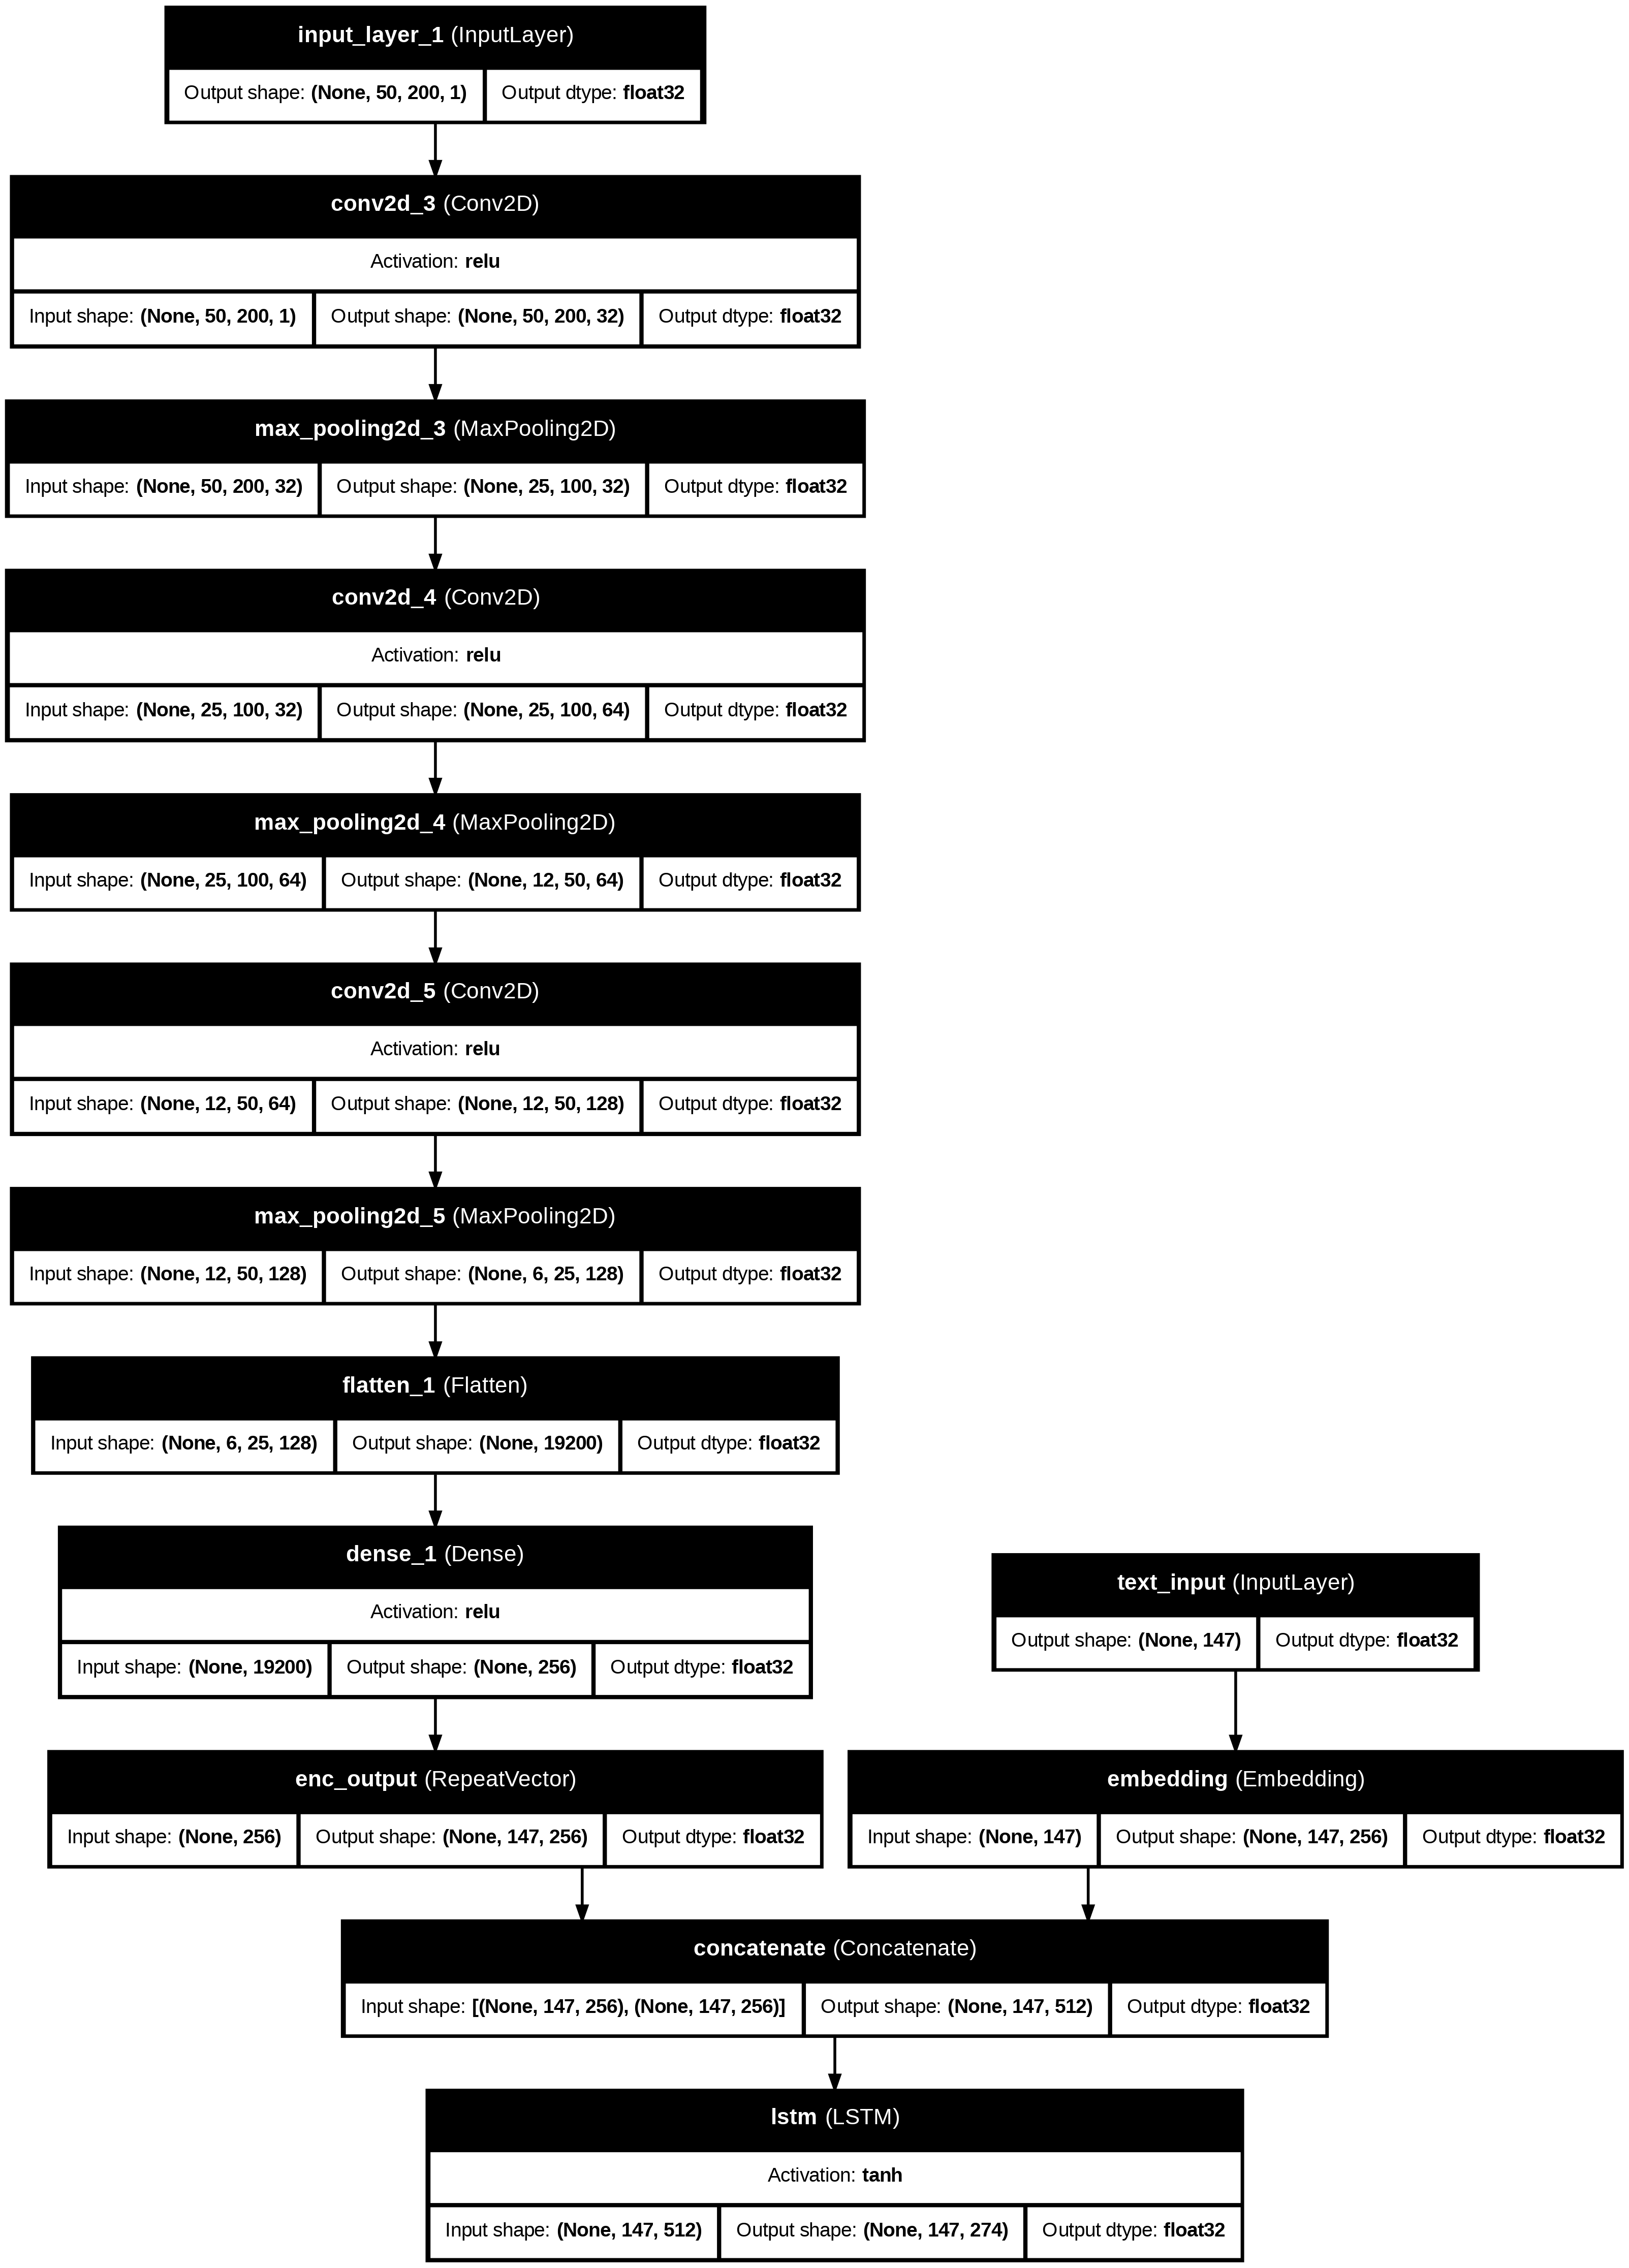

In [18]:
#dot_img_file =
import keras
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_dtype=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       )

In [19]:
model.fit([train_images, train_sequences], train_sequences,
          epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3141 - loss: 7.5256 - val_accuracy: 0.6181 - val_loss: 3.9027
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6170 - loss: 3.8689 - val_accuracy: 0.6202 - val_loss: 3.7118
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6321 - loss: 3.5497 - val_accuracy: 0.6270 - val_loss: 2.0896
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6233 - loss: 2.2319 - val_accuracy: 0.7029 - val_loss: 1.8326
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6867 - loss: 1.8553 - val_accuracy: 0.7064 - val_loss: 1.7219
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7017 - loss: 1.7481 - val_accuracy: 0.7205 - val_loss: 1.6457
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7168 - loss: 1.6639 - val_accuracy: 0.7293 - val_loss: 1.5911
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7283 - loss: 1.5842 - val_accuracy: 0.7293 - val_loss: